In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

In [2]:
bergen = pd.read_excel('data/working_sheet.xlsx')
# drop header and make row 0 the new header
bergen.columns = bergen.iloc[0]
# set row 0 to the header
bergen = bergen.reindex(bergen.index.drop(0))

# turn label Women into 0 and Men into 1
bergen['sex'] = bergen['sex'].replace(['Women', 'Men'], [0, 1])
# turn age_cat2 into categories: 40-59.9 = 0, 60-69.9 = 1, 70+ = 2
bergen['age_cat2'] = bergen['age_cat2'].replace(['40-59.9', '60-69.9', '70+'], [0, 1, 2])
# turn bodycomp into categories: normal = 0, cachetic = 1, obese = 2
bergen['bodycomp'] = bergen['bodycomp'].replace(['normal', 'cachectic', 'obese'], [0, 1, 2])
# turn smok_habits into categories: never = 0, ex = 1, daily = 2
bergen['smok_habits'] = bergen['smok_habits'].replace(['never', 'ex', 'daily'], [0, 1, 2])
# turn gold into categories: I/II = 0, III/IV = 1
bergen['gold'] = bergen['gold'].replace(['I/II', 'III/IV'], [1, 2])
# turn COPD_control into categories: control = 0, copd = 1
bergen['COPD_control'] = bergen['COPD_control'].replace(['control', 'copd'], [0, 1])

# turn all values that say 'no' to 0
bergen = bergen.replace('no', 0)
# turn all values that say 'yes' to 1
bergen = bergen.replace('yes', 1)

# set copd_exacerb_cat in all rows where COPD_control is 0 to 0
bergen.loc[bergen['COPD_control'] == 0, 'copd_exacerb_cat'] = 0
# set resp_failure in all rows where COPD_control is 0 to 0
bergen.loc[bergen['COPD_control'] == 0, 'resp_failure'] = 0
# set gold in all rows where COPD_control is 0 to 0
bergen.loc[bergen['COPD_control'] == 0, 'gold'] = 0
# turn packyrs_10 and wholelung950 into a float with 2 decimal points
bergen['packyrs_10'] = bergen['packyrs_10'].astype(float).round(2)
bergen['wholelung950'] = bergen['wholelung950'].astype(float).round(2)

# show histogram
# bergen.hist(bins=50, figsize=(20, 20))

###########
# missing values
###########

numeric_vars = ['packyrs_10', 'wholelung950']
for var in numeric_vars:
    bergen[var] = bergen[var].fillna(bergen[var].median())

# impute all other variables using mode
bergen = bergen.fillna(bergen.mode().iloc[0])

# drop cor_stenosis
bergen = bergen.drop(['cor_stenosis'], axis=1)
# use 



# show histogram
# bergen.hist(bins=50, figsize=(20, 15))

###########
# Scaling
###########

# use minmax scaling to scale everything except the target
target = bergen['copd_exacerb_cat']
bergen = bergen.drop(columns=['copd_exacerb_cat'])

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(bergen)
tmp = DataFrame(transf.transform(bergen), index=bergen.index, columns=bergen.columns)
bergen= concat([tmp, target], axis=1)

############
# Balancing
############



# use smote to balance the data
print(bergen['copd_exacerb_cat'].value_counts())

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(bergen.drop(columns=['copd_exacerb_cat']), bergen['copd_exacerb_cat'])
bergen = pd.DataFrame(X_res, columns=bergen.drop(columns=['copd_exacerb_cat']).columns)
bergen['copd_exacerb_cat'] = y_res

print(bergen['copd_exacerb_cat'].value_counts())

# save preprocessed dataset
bergen.to_excel('data/bergen_preprocessed.xlsx', index=False)

0.00    727
1.00     48
Name: copd_exacerb_cat, dtype: int64
0.00    727
1.00    727
Name: copd_exacerb_cat, dtype: int64


Accuracy: 0.7903780068728522


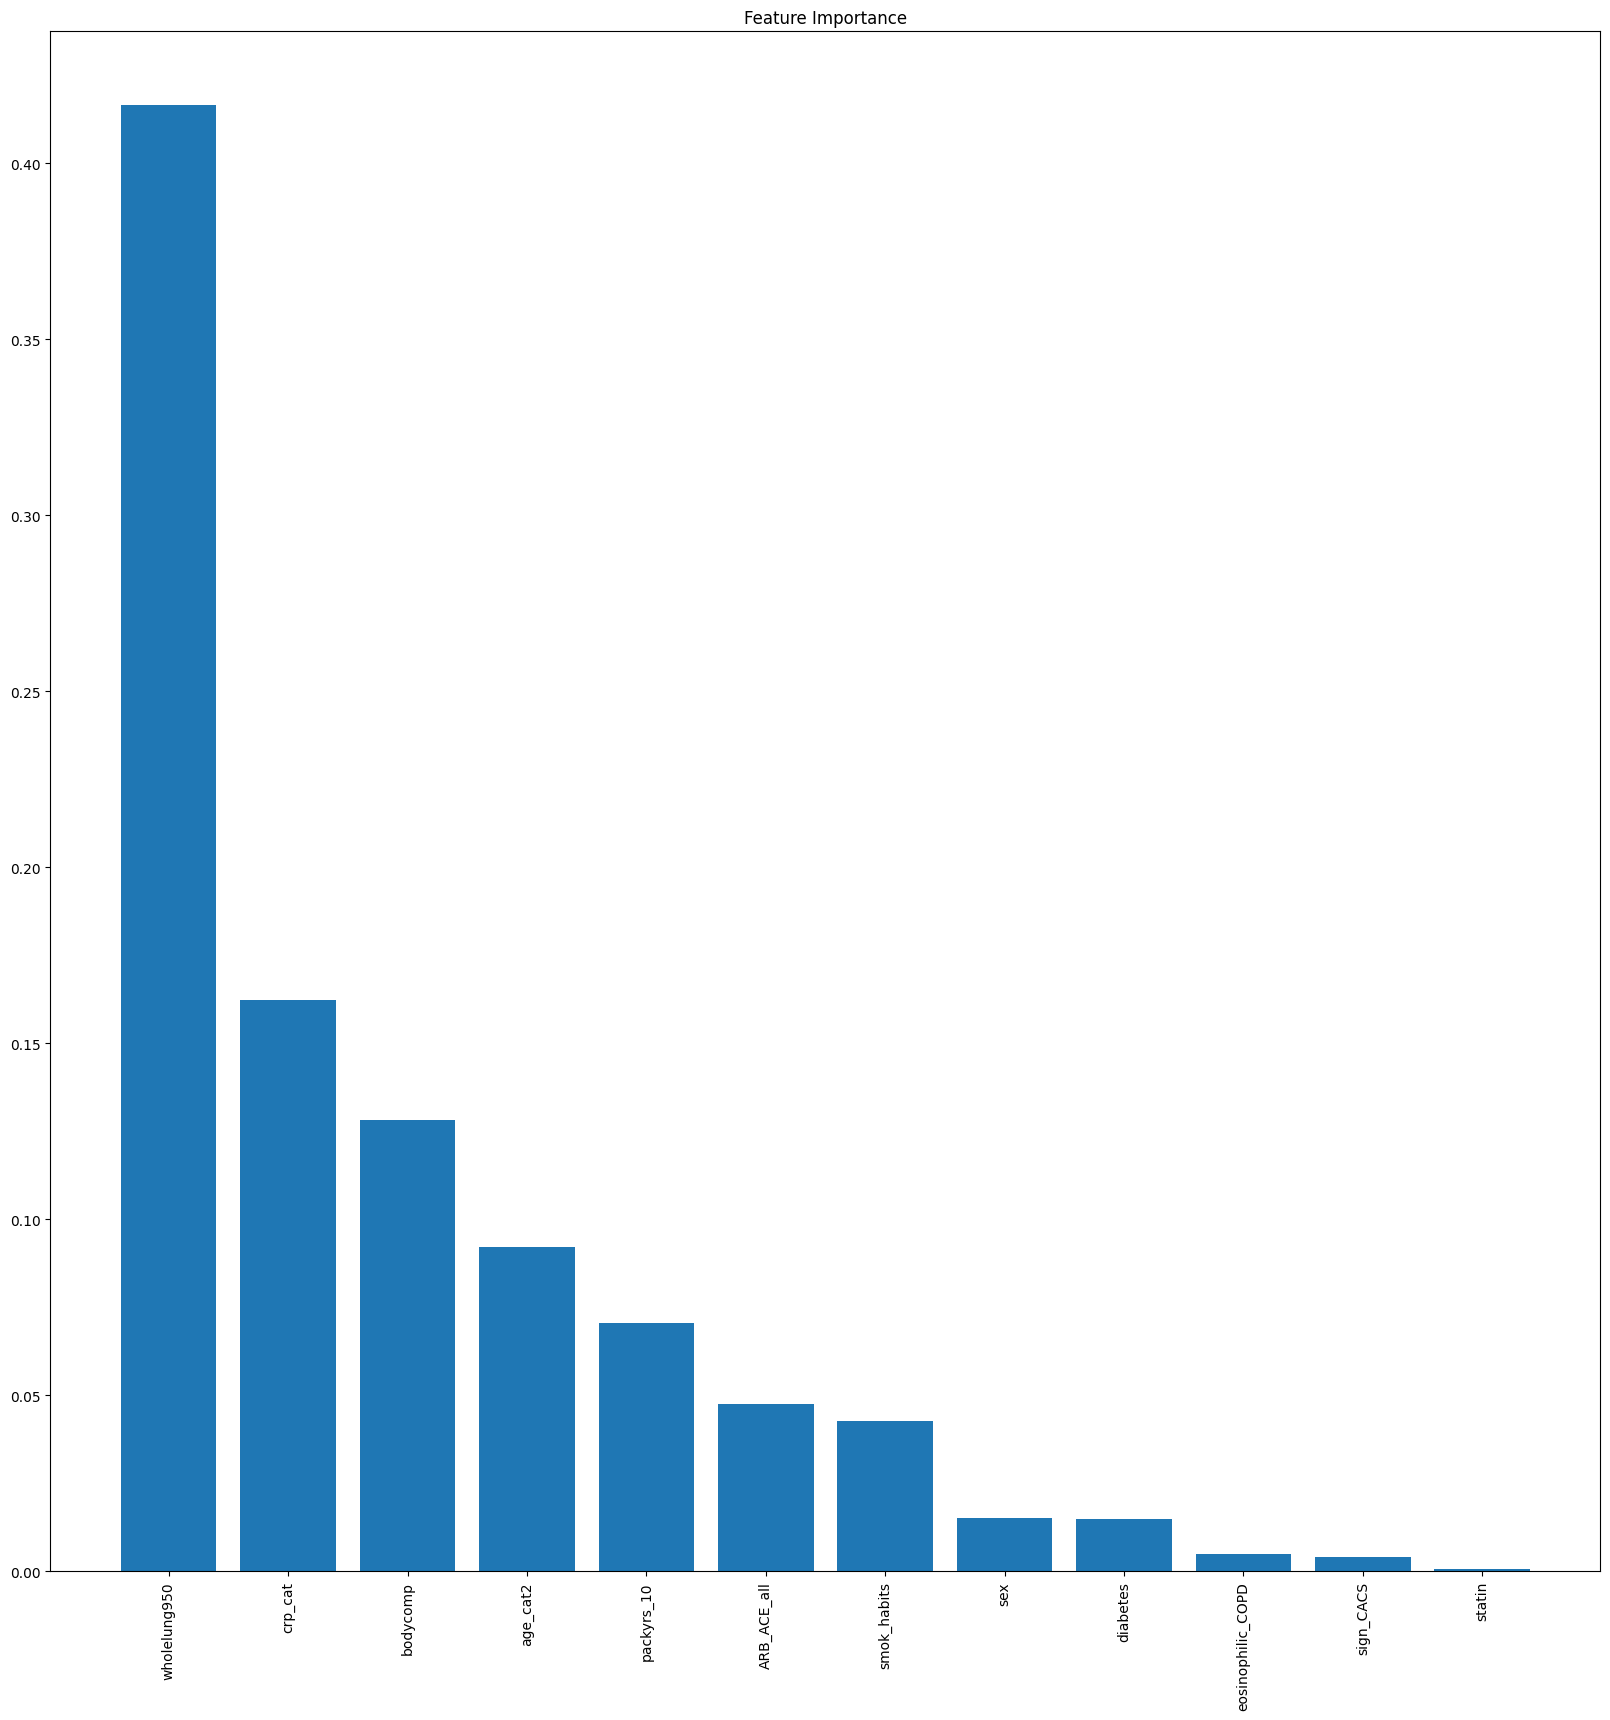

In [9]:
########
# Classification
########
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# drop correlated variables
bergen = bergen.drop(columns=['gold', 'COPD_control', 'resp_failure'])

X = bergen.drop(columns=['copd_exacerb_cat'])
y = bergen['copd_exacerb_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)
# models

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# get variable importances
importances = clf.feature_importances_
# sort in descending order
indices = np.argsort(importances)[::-1]
# rearrange feature names so they match the sorted feature importances
names = [bergen.columns[i] for i in indices]
# create plot
fig = plt.figure(figsize=(20,20))
plt.title("Feature Importance")
# add bars
plt.bar(range(X.shape[1]), importances[indices])
# add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)
# show plot
plt.show()


